# Staggered Grids

In [14]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import kernex as kex
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from jaxtyping import Array
import einops
import finitediffx as fdx
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.operators.functional import cgrid as C_grid
from jaxsw._src.boundaries import functional as F_bc
from jaxsw._src.domain.base import Domain
from jaxsw._src.fields.base import Field
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1-Dimensional

```python
+ -- ⋅ -- +
u -- u̅ -- u
+ -- ⋅ -- +
```


```python
# QOI
q: Array["Nx"] = ...
# U-Velocity
u: Array["Nx"] = ...
```

In [33]:
import typing as tp

In [34]:
ncols = 5

# initialize the Q domain
q_domain = Domain(xmin=(0,), xmax=(ncols,), dx=(1,))
values = q_domain.grid[..., 0]
q = Field(values, q_domain)


# initialize the u-velocity domain
u_domain = Domain(xmin=(0,), xmax=(ncols,), dx=(1,), stagger=("right",))
values = u_domain.grid[..., 0]
u = Field(values, u_domain)

q.values.shape, u.values.shape

((6,), (6,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


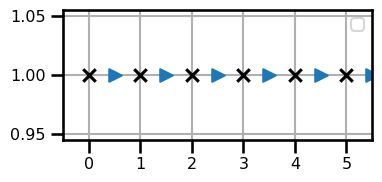

In [35]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(4, 2))

ax.scatter(q.values, jnp.ones_like(q.values), marker="x", color="black", zorder=2)
ax.scatter(u.values, jnp.ones_like(u.values), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set(xlim=[-0.5, ncols + 0.5])
ax.grid(which="major", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
jnp.pad(q.values.squeeze(), pad_width=((2, 2)), mode="reflect")

Array([2., 1., 0., 1., 2., 3., 4., 5., 4., 3.], dtype=float64)

In [37]:
u.domain.grid.shape

(6, 1)

In [42]:
print(q.values.squeeze(), q.values.shape)
q_on_u = F_grid.grid_operator(q, ("right",))
q_on_u.values, u.values

[0. 1. 2. 3. 4. 5.] (6,)
(6,)


(Array([0.5, 1.5, 2.5, 3.5, 4.5, 5. ], dtype=float64),
 Array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], dtype=float64))

In [43]:
q.domain.grid.shape

(6, 1)

In [45]:
u_on_q = F_grid.grid_operator(u, ("left",))
u_on_q.values, q.values

(6,)


(Array([0.5, 1. , 2. , 3. , 4. , 5. ], dtype=float64),
 Array([0., 1., 2., 3., 4., 5.], dtype=float64))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


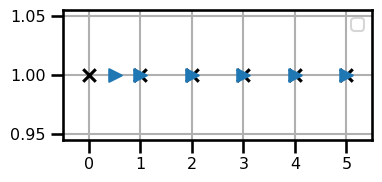

In [46]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(4, 2))

ax.scatter(q.values, jnp.ones_like(q.values), marker="x", color="black", zorder=2)
ax.scatter(
    u_on_q.values, np.ones_like(u_on_q.values), marker=">", color="tab:blue", zorder=2
)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set(xlim=[-0.5, ncols + 0.5])
ax.grid(which="major", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

### Nodes to Edges

This happens when we want to move the field defined on the field to the top-down edges.
For example, we may want to use the quantity of interest defined on the nodes to estimate the velocities defined on the top-down edges.

```python
# QOI
q: Array["Nx"] = ...
# U-Velocity
u: Array["Nx-1"] = ...
```

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


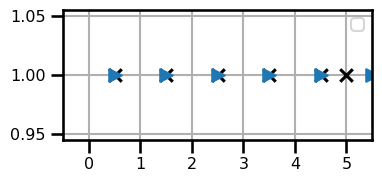

In [47]:
fig, ax = plt.subplots(figsize=(4, 2))

ax.scatter(
    q_on_u.values, np.ones_like(q_on_u.values), marker="x", color="black", zorder=2
)
ax.scatter(u.values, np.ones_like(u.values), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set(xlim=[-0.5, ncols + 0.5])
ax.grid(which="major", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

## Arakawa C-Grid

In this example, we will look at the classic Arakawa C-Grid.
This seems to be the standard for using standard finite difference methods on gridded domains.
All of the variables are on staggered domains which means that we will have to do some small transformations to put each variable on other domains.

In this example, we'll look at two variables along with their corresponding velocities.
The inspiration comes from the QG equation where we have

$$
\begin{aligned}
\partial_t q + \vec{u}\cdot q &= 0 \\
q = \boldsymbol{\nabla}_H \psi
\end{aligned}
$$

where we have four variables we need to handle in total:

* $q$ - potential vorticity on the cell faces
* $u$ - zonal velocity on the Top-Bottom cell edges
* $v$ - meridional velocity on the East-West cell edges
* $\psi$ - stream function on the cell nodes.

In [22]:
n_rows = 3
n_cols = 5

# Stream Function Domain - Cell Corners
psi_domain = Domain(xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1))
psi_x = Field(psi_domain.grid[..., 0], psi_domain)
psi_y = Field(psi_domain.grid[..., 1], psi_domain)

# Q Domain - cell faces
q_domain = Domain(
    xmin=(0.0, 0.0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=("right", "right")
)
q_x = Field(q_domain.grid[..., 0], q_domain)
q_y = Field(q_domain.grid[..., 1], q_domain)

# U Velocity -
u_domain = Domain(
    xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=("right", None)
)
u_x = Field(u_domain.grid[..., 0], u_domain)
u_y = Field(u_domain.grid[..., 1], u_domain)

# V Velocity
v_domain = Domain(
    xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=(None, "right")
)
v_x = Field(v_domain.grid[..., 0], v_domain)
v_y = Field(v_domain.grid[..., 1], v_domain)


# # initialize the Q domain
# q_domain = Domain(xmin=(0,), xmax=(ncols,), dx=(1,))
# values = q_domain.grid
# q = Field(values, q_domain)


# # initialize the u-velocity domain
# u_domain = Domain(xmin=(0,), xmax=(ncols,), dx=(1,), stagger=("right",))
# values = u_domain.grid
# u = Field(values, u_domain)
psi_x.values.shape

(4, 6)

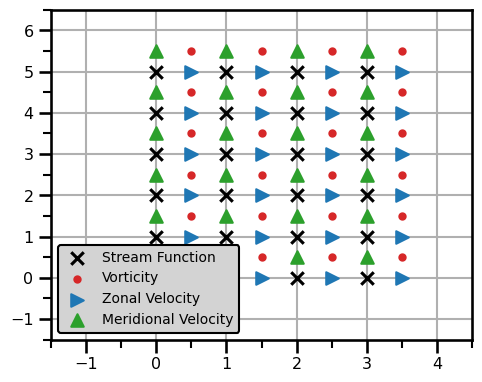

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x.values.ravel(),
    psi_y.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x.values.ravel(),
    q_y.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=2,
    label="Vorticity",
)
ax.scatter(
    u_x.values.ravel(),
    u_y.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x.values.ravel(),
    v_y.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

This example seems quite complicated and possibly unnecessary because we have two variables and the velocities.
This can occur in the contrived example but in many cases, we may only have 1 variable and the velocities, e.g. Shallow Water equations.
In this case, we have some options, we can use the cell faces as the main variable or the cell nodes.
It's up to us. 

### Transformations to Variable

In this first case, we will look at all transformations that can get us to the vorticity from any other variable on this grid.

$$
\begin{aligned}
\psi &\rightarrow q \\
u &\rightarrow q \\
v &\rightarrow q
\end{aligned}
$$

In [24]:
# def get_axis_operation(u, operation: str, padding):

#     opperation = list(operation)

#     if len(operation) == 1:
#         operation.append(None)

#     elif len(operation) == 2:
#         return F_grid.x_average_2D

#     elif len(operation) == 3:
#         return

#     elif operation.lower() == "left":
#         return F_grid.


#     return fn


def get_kernel_size(operations):
    msg = "too few/many operations. Need [1,3]"
    msg += f"\n{operations}"
    assert len(operations) <= 3 and len(operations) >= 1, msg

    if len(operations) == 1:
        if operations[0] is None:
            kernel_size = (1,)
        else:
            kernel_size = (2,)

    elif len(operations) == 2:
        x_op, y_op = operations
        do_something = ["right", "left", "inner", "outer"]
        case1 = x_op in do_something and y_op in do_something
        case2 = x_op is None and y_op in do_something
        case3 = x_op in do_something and y_op is None
        case4 = x_op is None and y_op is None

        if case1:
            kernel_size = (2, 2)
        elif case2:
            kernel_size = (1, 2)
        elif case3:
            kernel_size = (2, 1)
        elif case4:
            kernel_size = (1, 1)
        else:
            msg = "Unrecognized operations"
            msg += f"\nx - {x_op}"
            msg += f"\ny - {y_op}"
            raise ValueError(msg)

    elif len(operations) == 3:
        raise ValueError("Not Implemented")

    return kernel_size


def _field_operation_1D(u, operations, padding):
    kernel_size = get_kernel_size(operations)
    # print(kernel_size)
    # print(operations, padding, kernel_size)

    # pad values
    # print(u)
    u = jnp.pad(u, pad_width=padding, mode="edge")
    # print(u)

    # change values via the averaging
    u = F_grid.kernel_average(u, kernel_size=kernel_size, padding="valid")

    return u


def _domain_operation_1D(xmin, xmax, dx, operation):
    if operation is None:
        pass
    elif operation == "right":
        xmin += dx * 0.5
        xmax += dx * 0.5
    elif operation == "left":
        xmin -= dx * 0.5
        xmax -= dx * 0.5
    elif operation == "inner":
        xmin += dx * 0.5
        xmax -= dx * 0.5
    elif operation == "outer":
        xmin -= dx * 0.5
        xmax += dx * 0.5
    else:
        msg = f"Unrecognized argument for operation"
        msg += f"\noperation: {operation}"
        raise ValueError(msg)

    return xmin, xmax


def _axis_operation_2D(u, operation, padding):
    raise NotImplementedError()


#     # x operation
#     x_pad = padding[0] + (0,0)
#     print(x_pad)
#     values = jnp.pad(u.values.squeeze(), pad_width=padding[0], mode="constant")


#     return u


def _axis_operation_3D(u, operation, padding):
    raise NotImplementedError()

In [161]:
def grid_operator(u: Field, operations: tp.Iterable = None):
    assert len(u.domain.dx) == len(operations)

    pads = list()

    pads = [
        DEFAULT_PADDING[iop] if iop in list(DEFAULT_PADDING.keys()) else (0, 0)
        for iop in operations
    ]
    print(operations, pads)

    if len(u.domain.dx) == 1:
        # operate on field values
        u_values = _field_operation_1D(u.values.squeeze(), operations, pads)
        # operate on domain
        xmin, xmax = _domain_operation_1D(
            u.domain.xmin[0], u.domain.xmax[0], u.domain.dx[0], operations[0]
        )
        # create field
        # print(u_values.shape)
        return Field(
            u_values[..., None], Domain(xmin=(xmin,), xmax=(xmax,), dx=u.domain.dx)
        )

    elif len(u.domain.dx) == 2:
        # operate on field values
        u_values = _field_operation_1D(u.values.squeeze(), operations, pads)
        # operate on domain
        # print(u.domain.xmin, u.domain.xmax, u.domain.dx, operations)
        out = [
            _domain_operation_1D(xmin, xmax, dx, iop)
            for xmin, xmax, dx, iop in zip(
                u.domain.xmin, u.domain.xmax, u.domain.dx, operations
            )
        ]
        xmin, xmax = zip(*out)
        #         vmap_fn = jax.vmap(_domain_operation_1D, in_axes=(0,0,0,0))

        #         xmin, xmax = vmap_fn(
        #             jnp.asarray(u.domain.xmin),
        #             jnp.asarray(u.domain.xmax),
        #             jnp.asarray(u.domain.dx),
        #             jnp.asarray(operations))
        # print(xmin,xmax)
        return Field(u_values, Domain(xmin=xmin, xmax=xmax, dx=u.domain.dx))
        # # create field
        # # print(u_values.shape)
        # return Field(u_values[..., None], Domain(xmin=(xmin,), xmax=(xmax,), dx=u.domain.dx))

    elif len(u.domain.dx) == 3:
        raise NotImplementedError()

    # loop through operation to get padding based on semantics

    # get number of axis
    # check len(axis) == len(pad)

    # do operation on values
    # - pad (with method)
    # - move values around
    # update xmin/xmax on domain
    # - change xmin, xmax (not dx)
    # create new field

    return None

In [162]:
u.values.shape

(4, 6, 2)

In [25]:
u_x_on_q = F_grid.grid_operator(u_x, (None, "right"))
u_y_on_q = F_grid.grid_operator(u_y, (None, "right"))

v_x_on_q = F_grid.grid_operator(v_x, ("right", None))
v_y_on_q = F_grid.grid_operator(v_y, ("right", None))

psi_x_on_q = F_grid.grid_operator(psi_x, ("right", "right"))
psi_y_on_q = F_grid.grid_operator(psi_y, ("right", "right"))

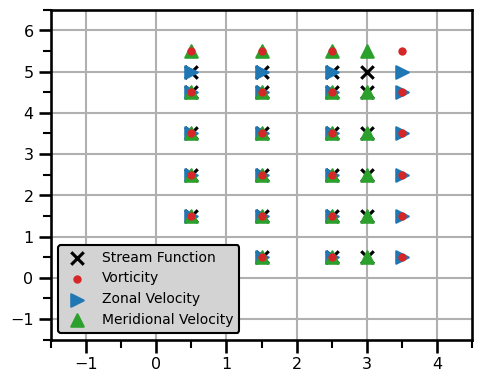

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x_on_q.values.ravel(),
    psi_y_on_q.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x.values.ravel(),
    q_y.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Vorticity",
)
ax.scatter(
    u_x_on_q.values.ravel(),
    u_y_on_q.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x_on_q.values.ravel(),
    v_y_on_q.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Transforms to PSI Variable

In this first case, we will look at all transformations that can get us to the vorticity from any other variable on this grid.

$$
\begin{aligned}
q &\rightarrow \psi \\
u &\rightarrow \psi \\
v &\rightarrow \psi
\end{aligned}
$$

In [27]:
u_x_on_psi = F_grid.grid_operator(u_x, ("left", None))
u_y_on_psi = F_grid.grid_operator(u_y, ("left", None))

v_x_on_psi = F_grid.grid_operator(v_x, (None, "left"))
v_y_on_psi = F_grid.grid_operator(v_y, (None, "left"))

q_x_on_psi = F_grid.grid_operator(q_x, ("left", "left"))
q_y_on_psi = F_grid.grid_operator(q_y, ("left", "left"))

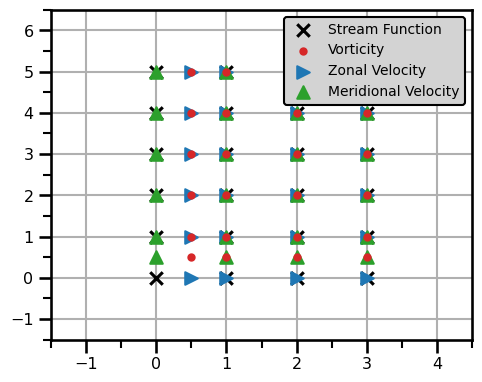

In [28]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x.values.ravel(),
    psi_y.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x_on_psi.values.ravel(),
    q_y_on_psi.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Vorticity",
)
ax.scatter(
    u_x_on_psi.values.ravel(),
    u_y_on_psi.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x_on_psi.values.ravel(),
    v_y_on_psi.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Transforms to U-Velocity

In this first case, we will look at all transformations that can get us to the u-velocity from any other variable on this grid.

$$
\begin{aligned}
q &\rightarrow u \\
\psi &\rightarrow u \\
v &\rightarrow u
\end{aligned}
$$

In [29]:
psi_x_on_u = F_grid.grid_operator(psi_x, ("right", None))
psi_y_on_u = F_grid.grid_operator(psi_y, ("right", None))

v_x_on_u = F_grid.grid_operator(v_x, ("right", "left"))
v_y_on_u = F_grid.grid_operator(v_y, ("right", "left"))

q_x_on_u = F_grid.grid_operator(q_x, (None, "left"))
q_y_on_u = F_grid.grid_operator(q_y, (None, "left"))

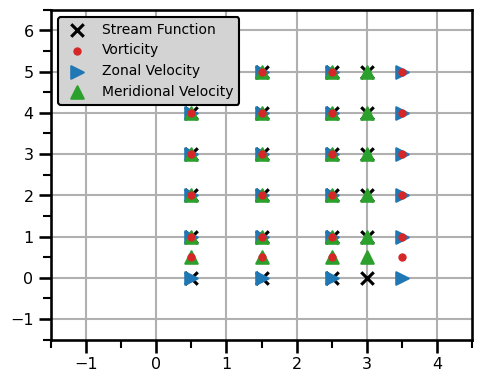

In [30]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x_on_u.values.ravel(),
    psi_y_on_u.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x_on_u.values.ravel(),
    q_y_on_u.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Vorticity",
)
ax.scatter(
    u_x.values.ravel(),
    u_y.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x_on_u.values.ravel(),
    v_y_on_u.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Transforms to V-Velocity

In this first case, we will look at all transformations that can get us to the v-velocity from any other variable on this grid.

$$
\begin{aligned}
q &\rightarrow v \\
\psi &\rightarrow v \\
u &\rightarrow v
\end{aligned}
$$

In [31]:
psi_x_on_v = F_grid.grid_operator(psi_x, (None, "right"))
psi_y_on_v = F_grid.grid_operator(psi_y, (None, "right"))

u_x_on_v = F_grid.grid_operator(u_x, ("left", "right"))
u_y_on_v = F_grid.grid_operator(u_y, ("left", "right"))

q_x_on_v = F_grid.grid_operator(q_x, ("left", None))
q_y_on_v = F_grid.grid_operator(q_y, ("left", None))

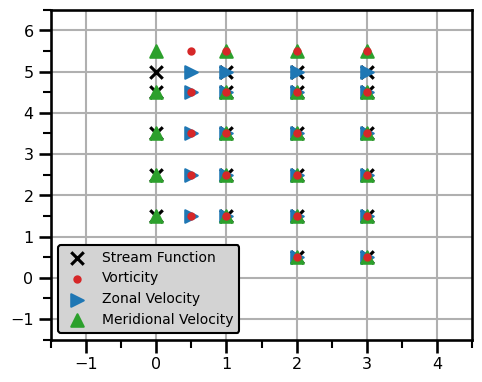

In [32]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x_on_v.values.ravel(),
    psi_y_on_v.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x_on_v.values.ravel(),
    q_y_on_v.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Vorticity",
)
ax.scatter(
    u_x_on_v.values.ravel(),
    u_y_on_v.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x.values.ravel(),
    v_y.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()